<a href="https://colab.research.google.com/github/Sidharth-Darwin/PyTorch_Programs/blob/main/SiameseNetworkMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [199]:
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.datasets import mnist
from torchvision.transforms import Compose, ToTensor

In [200]:
transform = Compose([ToTensor(),])

train = mnist.MNIST(root="/content/data", train=True, transform=transform, download=True)
test = mnist.MNIST(root="/content/data", train=False, transform=transform, download=True)

In [201]:
len(train), len(test)

(60000, 10000)

In [202]:
class SNDataset(Dataset):
    def __init__(self, ds):
        self.ds = ds
        self.len = len(ds)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        img1, lab1 = self.ds[idx]
        same_or_diff_label = random.randint(0, 1)
        if same_or_diff_label==1:
            lab2 = lab1
            while lab2 == lab1:
                img2, lab2 = self.ds[random.randint(0, self.len-1)]
        else:
            lab2 = -1
            while lab2 != lab1:
                img2, lab2 = self.ds[random.randint(0, self.len-1)]
        return (img1,
                img2,
                torch.tensor([same_or_diff_label], dtype=torch.float32))


In [203]:
train_ds = SNDataset(train)
test_ds = SNDataset(test)

In [204]:
len(train_ds), len(test_ds)

(60000, 10000)

In [205]:
del train

In [206]:
batch_size = 64

train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True
)

In [207]:
len(train_dl)

938

In [208]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),

            nn.Linear(in_features=256*3*3, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=1024, out_features=256),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=256, out_features=2)
        )

    def forward(self, img1, img2):
        out1 = self.model(img1)
        out2 = self.model(img2)
        return out1, out2


In [209]:
sn_model = SiameseNetwork()
sn_model

SiameseNetwork(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=2304, out_features=1024, bias=True)
    (11): ReLU(inplace=True)
    (12): Linear(in_features=1024, out_features=256, bias=True)
    (13): ReLU(inplace=True)
    (14): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [210]:
def distance_images(emb1, emb2):
    # Eucledian Distance
    d = F.pairwise_distance(emb1, emb2, keepdims=True)
    return d

In [211]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, emb1, emb2, label):
        D = distance_images(emb1, emb2)
        same_loss = (1 - label) * (D ** 2)
        diff_loss = label * (torch.clamp(self.margin - D, min=0.0) ** 2)
        return torch.mean(same_loss + diff_loss)

In [212]:
loss_fn = ContrastiveLoss()
# loss_fn(torch.randn(32, 10), torch.randn(32, 10), 1)
loss_fn

ContrastiveLoss()

In [213]:
optimizer = torch.optim.AdamW(sn_model.parameters(), lr=0.001)
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)

In [214]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [215]:
sn_model = sn_model.to(device)

In [216]:
n_epochs = 100
prev_loss = 1000000
prev_weights = None
print("Training ...")
for i in range(n_epochs):
    epoch_loss = 0
    for img1, img2, label in train_dl:
        img1 = img1.to(device)
        img2 = img2.to(device)
        label = label.to(device)
        emb1, emb2 = sn_model(img1, img2)
        loss = loss_fn(emb1, emb2, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {i+1} Loss {epoch_loss:.4f}")
    if epoch_loss > prev_loss:
        print("Earlystopping")
        sn_model.load_state_dict(prev_weights)
        break
    prev_loss = epoch_loss
    prev_weights = sn_model.state_dict()

Training ...
Epoch 1 Loss 272.0584
Epoch 2 Loss 94.9567
Epoch 3 Loss 56.6032
Epoch 4 Loss 37.2997
Epoch 5 Loss 32.9754
Epoch 6 Loss 25.5717
Epoch 7 Loss 23.2852
Epoch 8 Loss 15.3044
Epoch 9 Loss 14.8905
Epoch 10 Loss 16.3418
Earlystopping


In [217]:
similarity_score = lambda emb1, emb2: torch.exp(-distance_images(emb1, emb2))

In [237]:
for i in range(10):
    img1, img2, label = random.choice(test_ds)
    img1, img2, label = img1.to(device), img2.to(device), label.to(device)
    img1, img2 = img1.unsqueeze(0), img2.unsqueeze(0)
    emb1, emb2 = sn_model(img1, img2)
    print(f"{'Diff' if label.item()==1 else 'Same'}\tSimilarity: {similarity_score(emb1, emb2).item()*100:.2f}%")

Same	Similarity: 92.49%
Diff	Similarity: 10.57%
Same	Similarity: 95.09%
Diff	Similarity: 10.53%
Diff	Similarity: 1.29%
Diff	Similarity: 11.40%
Diff	Similarity: 2.29%
Diff	Similarity: 1.88%
Same	Similarity: 97.37%
Diff	Similarity: 11.81%


In [239]:
torch.save(sn_model, f='model.pth')

In [240]:
model = torch.load(f="model.pth")

<ipython-input-240-4d32d9e85c48>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f="model.pth")


In [242]:
import matplotlib.pyplot as plt

[]

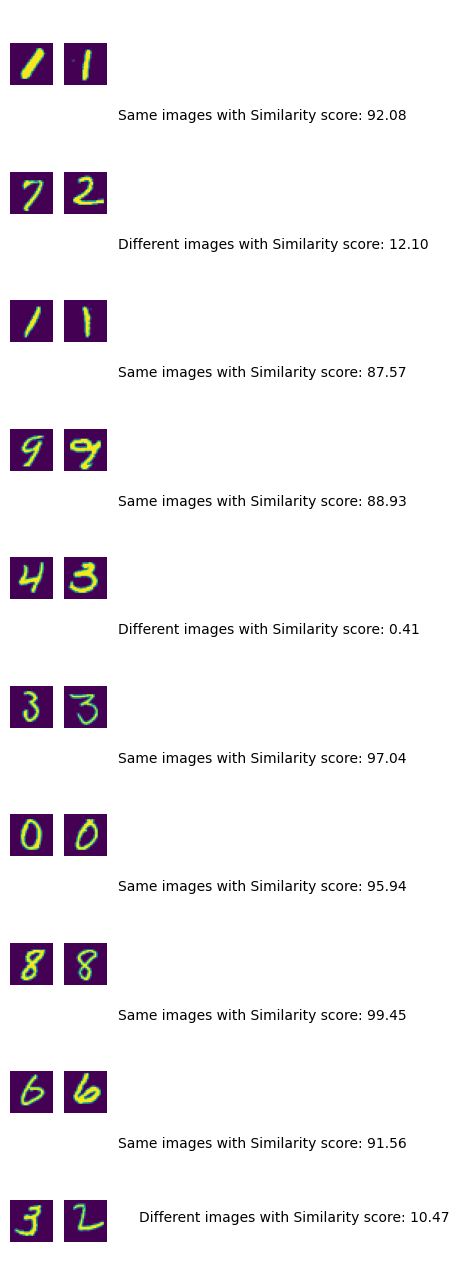

In [252]:
n_egs = 10
fig, axs = plt.subplots(nrows=n_egs, ncols=3, figsize=(4, 13))
for i in range(n_egs):
    img1, img2, label = random.choice(test_ds)
    img1, img2, label = img1.to(device), img2.to(device), label.to(device)
    img1, img2 = img1.unsqueeze(0), img2.unsqueeze(0)
    emb1, emb2 = sn_model(img1, img2)
    s_score = similarity_score(emb1, emb2).item()*100
    axs[i][0].imshow(img1.cpu().numpy().squeeze())
    axs[i][1].imshow(img2.cpu().numpy().squeeze())
    axs[i][2].text(0, 0, f"{'Same' if label.item()==0 else 'Different'} images with Similarity score: {s_score:.2f}")
    axs[i][0].axis(False)
    axs[i][1].axis(False)
    axs[i][2].axis(False)
fig.tight_layout()
plt.plot()